## Import Packages

Here, we import TALib, a python library which alows us to quickly calculate some important sentiment indicators

In [209]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3




  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3797    0  3797    0     0  16366      0 --:--:-- --:--:-- --:--:-- 16296
100  503k  100  503k    0     0   815k      0 --:--:-- --:--:-- --:--:--  815k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3817    0  3817    0     0  18529      0 --:--:-- --:--:-- --:--:-- 18529
100  406k  100  406k    0     0   723k      0 --:--:-- --:--:-- --:--:-- 3027k


Here, we import the data files from google drive. For this to work properly, please import the github files into colab. Otherwise, the variable paths will have to be modified

In [210]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/My Drive/APS1052_project/'
data_dir1 = '/content/drive/My Drive/Algorithm/SPY_data.csv'
data_dir2 = '/content/drive/My Drive/Algorithm/VIX.xlsx'
data_dir3 = '/content/drive/My Drive/Algorithm/DIX.csv'
data_dir4 = '/content/drive/My Drive/Algorithm/pcratio.xlsx'
data_dir5 = '/content/drive/My Drive/Algorithm/fff.csv'

import os
os.chdir(data_dir)
!ls


Mounted at /content/drive
 APS_Project.ipynb   fff.csv	    'Results\Residuals.png'
 catboost_info	     inflation.csv   sntwiabl8vwxvs4i.csv
 detrendPrice.py     logs.log	     SPY_data.csv
 DIX.csv	     pcratio.xlsx    VIX.xlsx
 fAux.py	     __pycache__     WhiteRealityCheckFor1.py


Here we import all the libaries and modules that we'll need to build our model. 

In [211]:
import pandas as pd
import os
import fAux
import WhiteRealityCheckFor1
import detrendPrice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import talib as ta
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
import detrendPrice 
import WhiteRealityCheckFor1 
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVR

## Import and Process Data

The sources for all data used in this project can be made available upon request. Our main dataframe is going to be df, which contains the daily stock data of SPY from 2000. We will add any other useful indicators to this dataframe. To start, I've  just set the index to the date in a datetime format. This should allow us to easily add new columns, if needed, based on the date of the data.

Also, to train our model properly, we want to exclude any anomalies in the data. This means that we should remove the 2008 stock crash from the training set. The 2020 crash can remain in the test data - however the results should be analyzed with caution

In [212]:
df = pd.read_csv(data_dir1)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
#df.drop(['date'], axis=1, inplace=True)
df.head()

,PERMNO,TICKER,HSICMG,BIDLO,ASKHI,PRC,VOL,OPENPRC,sprtrn
date,,,,,,,,,
2000-01-03,84398,SPY,NaN,143.87500,148.25000,145.4375,8164299,148.25000,-0.009549
2000-01-04,84398,SPY,NaN,139.64063,144.06250,139.7500,8089799,143.53125,-0.038345
2000-01-05,84398,SPY,NaN,137.25000,141.53125,140.0000,12177899,139.93750,0.001922
2000-01-06,84398,SPY,NaN,137.75000,141.50000,137.7500,6227199,139.62500,0.000956
2000-01-07,84398,SPY,NaN,140.06250,145.75000,145.7500,8066599,140.31250,0.027090


Next, we'll do the same for the VIX dataset, which is the CBOE volatility index.

In [213]:
vix = pd.read_excel(data_dir2)
vix['date'] = pd.to_datetime(vix['Date'])
vix = vix.set_index('date')
vix.drop(['Date'], axis=1, inplace=True)
vix.columns = ['vix']
vix.head()

,vix
date,
2009-01-02,39.58
2009-01-05,39.24
2009-01-06,38.06
2009-01-07,40.29
2009-01-08,43.38


And for the DIX dataset, which contains the dark pool index (dix) and the gamma exposure index (gex)

In [214]:
dix = pd.read_csv(data_dir3)
dix['date'] = pd.to_datetime(dix['date'])
dix = dix.set_index('date')
dix.drop(['price'], axis=1, inplace=True)
dix.head()

,dix,gex
date,,
2011-05-02,0.378842,1.897313e+09
2011-05-03,0.383411,1.859731e+09
2011-05-04,0.392122,1.717764e+09
2011-05-05,0.405457,1.361864e+09
2011-05-06,0.418649,1.490329e+09


And finally, we will process the put/call ratio, which is a ratio of the number of put contracts to the number of call contracts. This will give us an idea of the market sentiment, based on which we will make our trades. For this project, I decided to calculate the ratio ourselves from the options volumes. The options volume dataset is presented in a slightly unintuitive fashion, so we will have to clean it up first.

In [215]:
pcratio = pd.read_excel(data_dir4)
pcratio.columns = ['ID', 'date', 'flag', 'inflag', 'vol']
calls = pcratio[pcratio['flag']=='C']
puts = pcratio[pcratio['flag']=='P']
calls.drop(['ID', 'flag', 'inflag'], axis=1)
puts.drop(['ID', 'flag', 'inflag'], axis=1)
calls['ratio'] = puts['vol'].values/calls['vol'].values
ratio = calls.copy()
ratio.drop(['ID', 'flag', 'inflag', 'vol'], axis=1, inplace=True)
ratio['date'] = pd.to_datetime(ratio['date'])
ratio = ratio.set_index('date')
ratio


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,ratio
date,
2005-01-10,0.834598
2005-01-11,1.134168
2005-01-12,1.413229
2005-01-13,1.800911
2005-01-14,0.632647
...,...
2020-12-24,1.388211
2020-12-28,1.380474
2020-12-29,1.877185


Next, we will also include the Fama-French factors, which are some key indicators of the S&P500. Since the SPY ETF tracks the S&P, I thought it might be helpful to include them.

In [216]:
fff = pd.read_csv(data_dir5)
fff['date'] = pd.to_datetime(fff['date'], format='%Y%m%d')
fff = fff.set_index('date')
fff = fff.drop('RF', axis = 1)
df['Mkt-RF'] = fff['Mkt-RF']
df['SMB'] = fff['SMB']
df['HML'] = fff['HML']
df['RMW'] = fff['RMW']
df['CMA'] = fff['CMA']
fff

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2006-01-03,1.50,-0.14,0.18,0.18,-0.32
2006-01-04,0.46,0.31,0.03,-0.44,0.33
2006-01-05,0.03,0.23,-0.10,-0.55,0.19
2006-01-06,0.92,0.09,-0.24,-0.03,0.14
2006-01-09,0.45,0.51,-0.16,0.06,-0.04
...,...,...,...,...,...
2020-12-24,0.21,-0.43,-0.18,0.23,-0.06
2020-12-28,0.46,-0.67,0.34,1.39,0.46
2020-12-29,-0.40,-1.42,0.23,0.75,-0.30


# Calulate Input Features

Now, we will calculate some other input features that aren't readily/easily available through other sources

We will choose a 2 wee (14 day) lookback window, which is a reasonable standard for daily stock data. We do not need all this data for training. Some useful variables will be excluded from the dataframe to avoid using them in training, but will be saved for later reference

An important dummy variable we will create is the day of the week. In order to represent patterns which occur on a weekly basis on a specific trading day, we will assign each day of the week with a number. For example, Monday will be assigned with 1, Tuesday with 2, and so on.

In [217]:
orig_cols = df.columns.values.tolist()
openp = df['OPENPRC'].copy()
high = df['ASKHI'].shift(1)
low = df['BIDLO'].shift(1)
close = df['PRC'].shift(1)

n=14
df['RSI']=ta.RSI(np.array(close), timeperiod=n)
df['SMA'] = close.rolling(window=n).mean()
df['Corr']= close.rolling(window=n).corr(df['SMA'])
df['SAR']=ta.SAR(np.array(high),np.array(low), 0.2,0.2)
df['ADX']=ta.ADX(np.array(high),np.array(low), np.array(df['OPENPRC']), timeperiod =n)
df['OO']= df['OPENPRC']-df['OPENPRC'].shift(1)
df['OC']= df['OPENPRC']-close
df['putcallratio'] = ratio['ratio']
putcallratio = ratio['ratio']
df.fillna(0, inplace=True)

df["day"] = df.index.dayofweek.values
df_dummies_day = pd.get_dummies(df["day"], prefix='day')
df=df.join(df_dummies_day)
#df.drop(["day"], axis=1, inplace=True)
df1 = df.tail(3200)
df1

,PERMNO,TICKER,HSICMG,BIDLO,ASKHI,PRC,VOL,OPENPRC,sprtrn,Mkt-RF,SMB,HML,RMW,CMA,RSI,SMA,Corr,SAR,ADX,OO,OC,putcallratio,day,day_0,day_1,day_2,day_3,day_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-04-18,84398,SPY,67.0,138.25999,139.56000,138.48000,218530600,138.94000,0.018139,1.67,0.11,-0.58,0.36,-0.36,57.202226,135.592144,0.025471,132.330000,13.914469,2.92000,1.89000,1.298380,4,0,0,0,0,1
2008-04-21,84398,SPY,67.0,136.87000,138.98000,138.55000,118587400,138.23000,-0.001554,-0.17,-0.16,-0.65,0.26,-0.41,60.653950,136.057144,-0.136731,133.314000,14.685142,-0.71000,-0.25000,1.628117,0,1,0,0,0,0
2008-04-22,84398,SPY,67.0,136.64000,138.37000,137.94000,162166100,138.19000,-0.008810,-0.97,-1.09,0.37,0.06,-0.37,60.820529,136.195716,0.072631,134.563200,14.693198,-0.04000,-0.36000,2.547629,1,0,1,0,0,0
2008-04-23,84398,SPY,67.0,137.12000,138.78000,137.72000,193309000,138.09000,0.002900,0.26,0.11,-1.20,-0.19,0.25,58.496377,136.284287,0.232588,135.562560,14.586227,-0.10000,0.15000,1.532141,2,0,0,1,0,0
2008-04-24,84398,SPY,67.0,137.03999,139.74001,138.32001,229381400,138.08000,0.006442,0.66,0.59,0.50,-0.54,0.34,57.640872,136.332859,0.419957,136.362048,14.648699,-0.01000,0.36000,1.394924,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,84398,SPY,67.0,367.45001,369.03000,369.00000,26457853,368.07999,0.003537,0.21,-0.43,-0.18,0.23,-0.06,57.157480,368.392858,-0.037166,362.030000,23.264808,-0.20001,0.50998,1.388211,3,0,0,0,1,0
2020-12-28,84398,SPY,67.0,371.07001,372.59000,372.17001,39000402,371.73999,0.008723,0.46,-0.67,0.34,1.39,0.46,59.393363,368.332143,0.101023,365.315998,23.965289,3.66000,2.73999,1.380474,0,1,0,0,0,0
2020-12-29,84398,SPY,67.0,370.82999,374.00000,371.45999,53680451,373.81000,-0.002227,-0.40,-1.42,0.23,0.75,-0.30,63.892082,368.552144,0.296081,367.217190,25.166677,2.07001,1.63999,1.877185,1,0,1,0,0,0


# Visualize data

Now we want to visualize the data to ensure that there are no abnormalities or undesired patterns in the data that may bias or reduce the viability of the results.

First, we will use the tsplot function to conduct a time series analysis on a random snapshot of the put/call ratio.

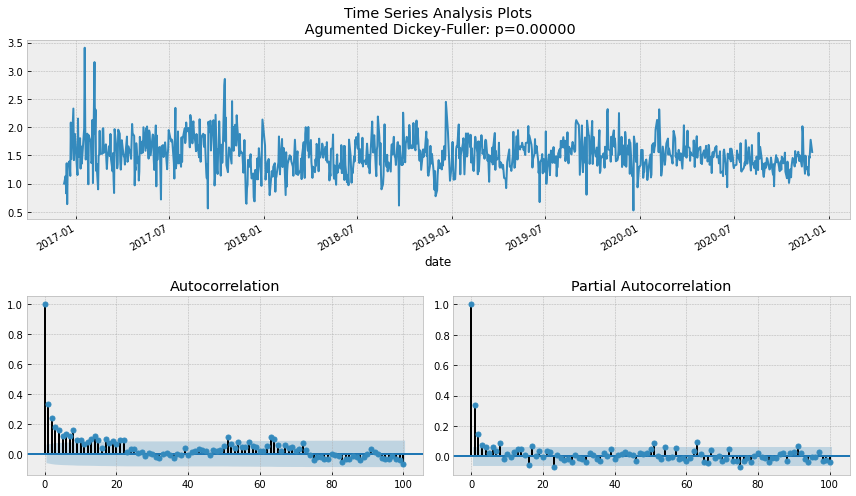

In [218]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries pandas series
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Agumented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
tsplot(putcallratio[3000:4000], lags=100)

Based on the above results, we can see that there the put/call ratio is not autocorrelated.

## Build Target

Entering a trade at the market open is generally better than entering at the close. Thus, we will calculate our target returns using the open price of tomorrow's trading day. This will allow us to determine whether we are gaining or losing money with our predictions, showing our model "correct" behavior. We will fill any na values with 0 to avoid errors in training

We will also save the future returns in order to calculate our system returns  based on the our predicted positions later on.


In [219]:
df['retFut1'] = df['OPENPRC'].pct_change(1).shift(-1).fillna(0) #if you enter the trade at the open
#df['retFut1'] = df['PRC'].pct_change(1).shift(-1).fillna(0) #if you wait until the close to enter the trade
df['pcratio1'] = ratio['ratio'].shift(-1).fillna(0)


#Preserve for calculations of system return
retFut1 = df['retFut1'].copy()
#RSI1 = df['RSI1'].copy()

## Create Lags 


Now that we have all our data, the last step is to create the lags. Again, we will use a 2 week (14 day) lookback window. Once that is done, we can do a train-test split and start training our model.

## Split Train and Test Data

We will start our training at the end of 2009, well past the stock market crash. Because we have a large number of data points (over 10 years worth of data), our train set will be 2/3 of the total dataset. The quotient will be used in the test set

In [220]:
for n in list(range(0,15)):
    name = 'putcallratio' + str(n)
    df[name] =  ratio['ratio'].shift(n).fillna(0)

orig_cols = ['TICKER','HSICMG','sprtrn','PRC','VOL','PERMNO','BIDLO','ASKHI','OPENPRC','putcallratio', 'retFut1', 'day']#keep the open

df.drop(orig_cols, axis=1, inplace=True)

X = df.drop(['pcratio1'], axis=1)
y = df[['pcratio1']]

start = 2500
end = 5284

x_train = X.iloc[start:start+int((end-start)*2/3)]
x_test = X.iloc[start+int((end-start)*2/3):]

y_train = y.iloc[start:start+int((end-start)*2/3)]
y_test = y.iloc[start+int((end-start)*2/3):]

retFut1_train = retFut1[start:start+int((end-start)*2/3)]
retFut1_test = retFut1[start+int((end-start)*2/3):]

ratio_train = x_train['putcallratio0']
ratio_test = x_test['putcallratio0']

Now, we can create a correlation matrix to ensure that none of the variables are highly correlated with each other.

Notably,OO and OC are quite significatly correlated. This is not an issue, as they simply represent the price difference between open to open (24 hours) and open to close (6.5 hours). In essence, this keeps track of the after market volatility of the market, so it makes sense that they are correlated. 

We can also notice that the put call ratio of the previous trading day is slightly correlated with the next day's. This is also to be expected, as the ratio of the previous day will be our most significant indicator in predicting the next day's ratio.

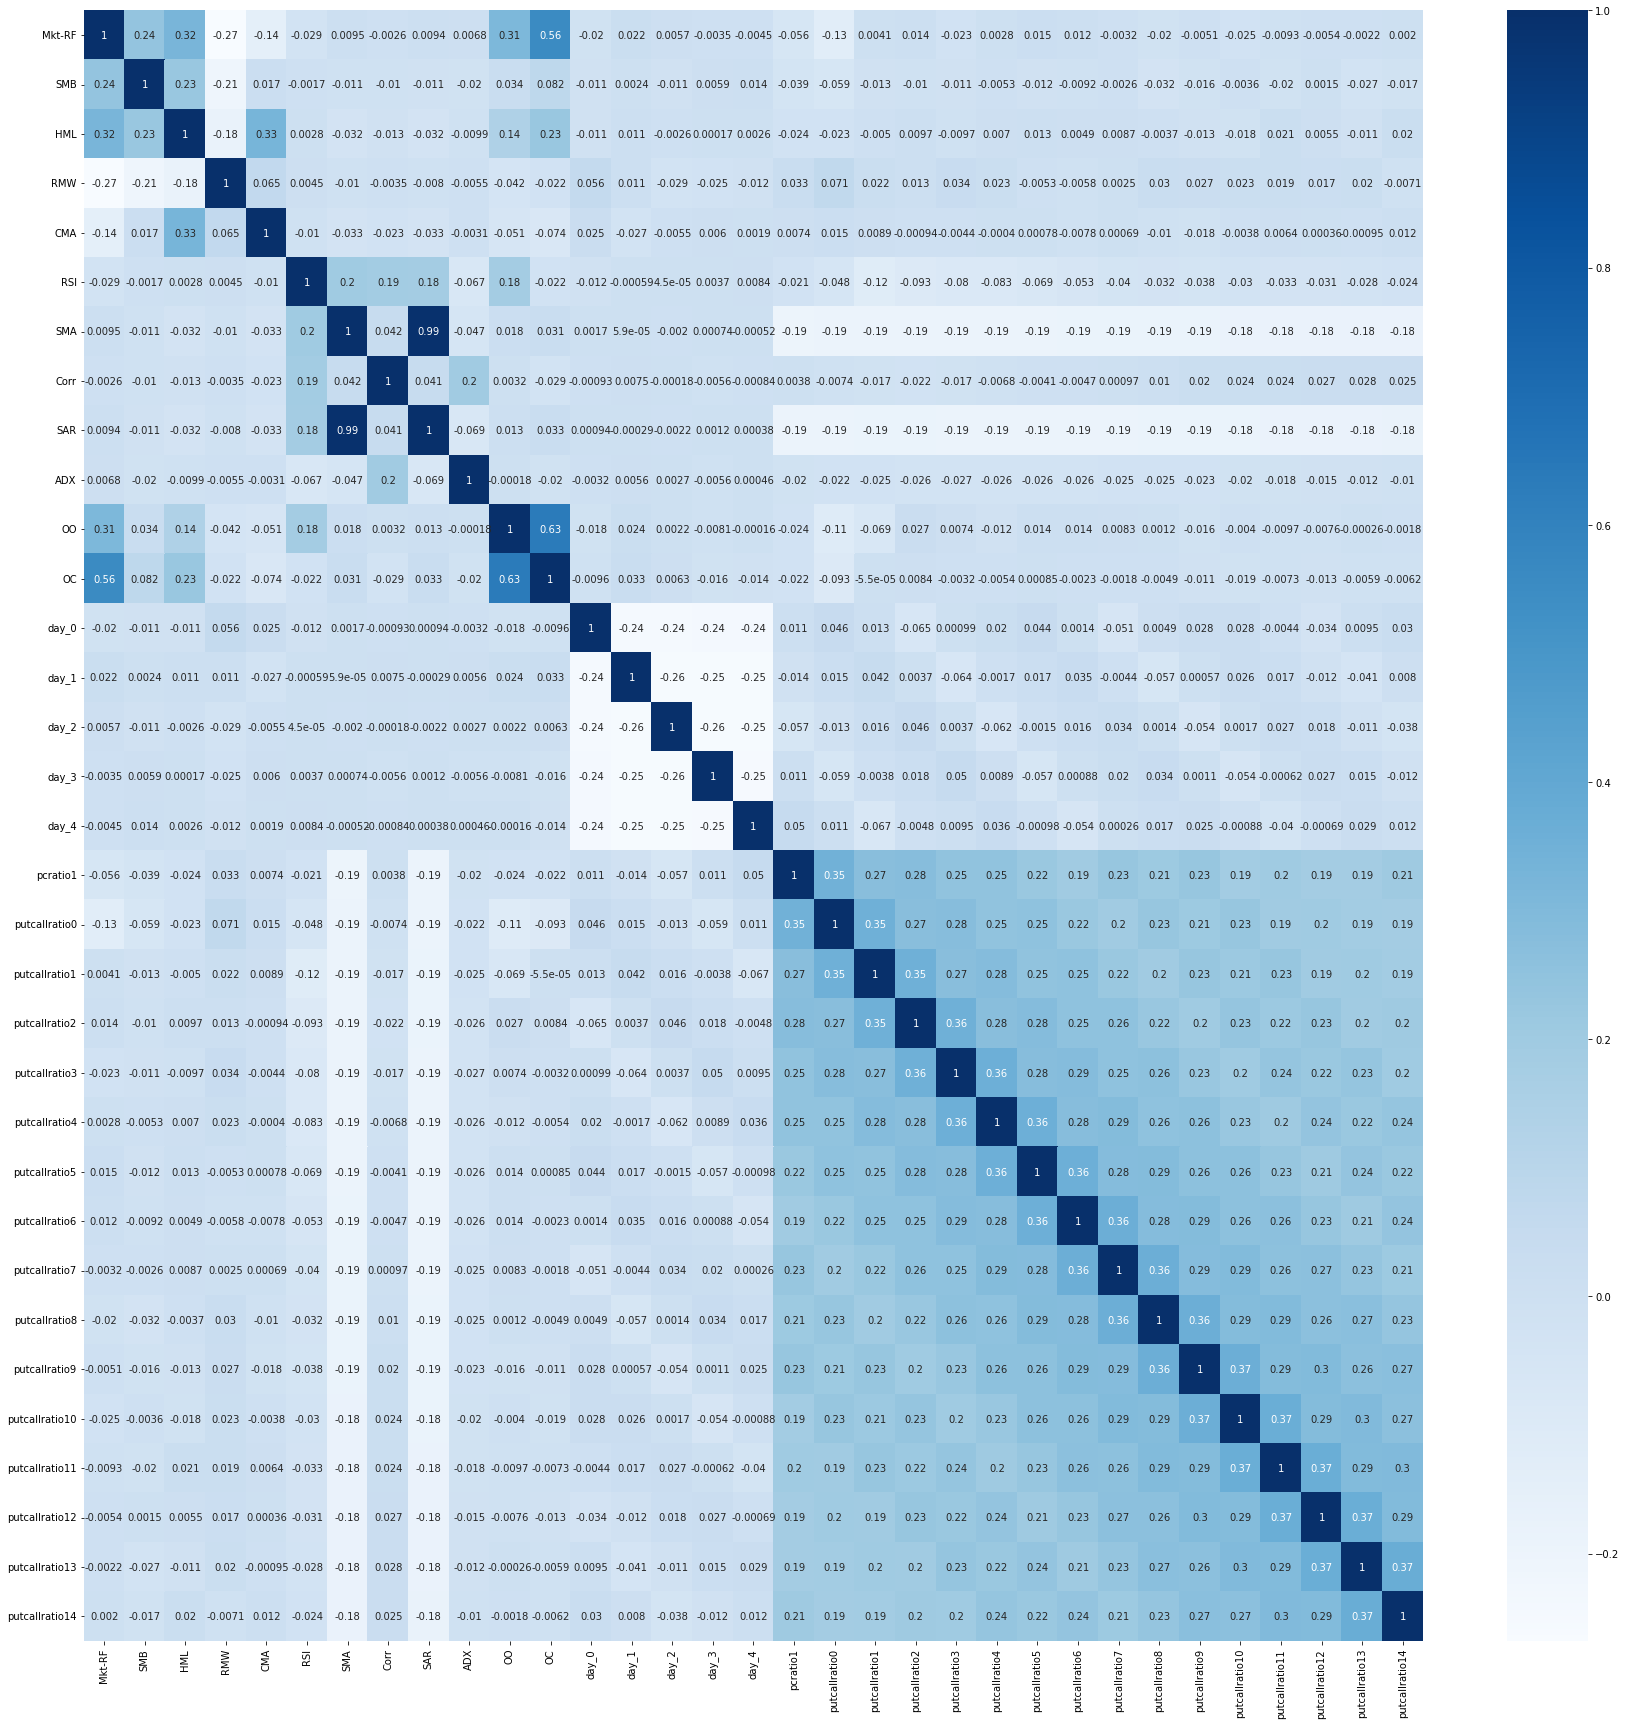

In [221]:
corr = df.corr()
plt.figure(figsize=[30,30])
sns.heatmap(corr, cmap="Blues", annot=True )


Now, we will show the train and test sets, along with the targets for reference

In [222]:
x_train

,Mkt-RF,SMB,HML,RMW,CMA,RSI,SMA,Corr,SAR,ADX,OO,OC,day_0,day_1,day_2,day_3,day_4,putcallratio0,putcallratio1,putcallratio2,putcallratio3,putcallratio4,putcallratio5,putcallratio6,putcallratio7,putcallratio8,putcallratio9,putcallratio10,putcallratio11,putcallratio12,putcallratio13,putcallratio14
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-10,0.50,-0.93,-0.10,0.51,-0.26,52.032735,110.454357,0.330304,111.758000,13.993848,1.12000,0.67900,0,0,0,1,0,1.556448,1.646560,1.210624,1.476973,1.345370,1.620531,2.480102,1.423572,1.899283,1.982689,1.499759,1.664408,1.686427,1.344931,1.379330
2009-12-11,0.43,0.43,0.49,0.22,0.25,54.742965,110.512929,0.226880,111.210400,13.066908,0.41000,0.47000,0,0,0,0,1,1.602364,1.556448,1.646560,1.210624,1.476973,1.345370,1.620531,2.480102,1.423572,1.899283,1.982689,1.499759,1.664408,1.686427,1.344931
2009-12-14,0.80,0.73,0.32,-0.21,-0.66,56.741556,110.632929,-0.103169,109.020000,12.236222,0.76000,0.76000,1,0,0,0,0,1.801706,1.602364,1.556448,1.646560,1.210624,1.476973,1.345370,1.620531,2.480102,1.423572,1.899283,1.982689,1.499759,1.664408,1.686427
2009-12-15,-0.48,0.17,-0.61,0.42,-0.32,59.830663,110.707929,0.091610,112.000000,13.859429,-0.41000,-0.41000,0,1,0,0,0,1.285725,1.801706,1.602364,1.556448,1.646560,1.210624,1.476973,1.345370,1.620531,2.480102,1.423572,1.899283,1.982689,1.499759,1.664408
2009-12-16,0.19,0.51,0.71,-0.43,0.06,56.839849,110.733643,0.324244,112.000000,15.366692,0.34000,0.45000,0,0,1,0,0,0.927508,1.285725,1.801706,1.602364,1.556448,1.646560,1.210624,1.476973,1.345370,1.620531,2.480102,1.423572,1.899283,1.982689,1.499759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-20,0.83,0.60,0.26,0.23,-0.20,43.283965,234.791429,0.663677,232.509990,15.840081,-0.37001,0.70999,0,0,0,1,0,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158,1.385611,1.833828,1.505094,1.337268,1.469032,1.478633,1.525348,1.769471,1.402758
2017-04-21,-0.28,0.06,-0.15,0.34,-0.19,52.335975,234.723572,0.444123,232.997992,14.857748,1.10001,-0.09000,0,0,0,0,1,1.890246,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158,1.385611,1.833828,1.505094,1.337268,1.469032,1.478633,1.525348,1.769471
2017-04-24,1.18,0.28,0.50,-0.06,0.16,49.010737,234.641429,0.309013,233.179990,13.945581,1.92999,2.58999,1,0,0,0,0,1.845910,1.890246,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158,1.385611,1.833828,1.505094,1.337268,1.469032,1.478633,1.525348


In [223]:
y_train

,pcratio1
date,
2009-12-10,1.602364
2009-12-11,1.801706
2009-12-14,1.285725
2009-12-15,0.927508
2009-12-16,0.362891
...,...
2017-04-20,1.890246
2017-04-21,1.845910
2017-04-24,0.968572


In [224]:
x_test

,Mkt-RF,SMB,HML,RMW,CMA,RSI,SMA,Corr,SAR,ADX,OO,OC,day_0,day_1,day_2,day_3,day_4,putcallratio0,putcallratio1,putcallratio2,putcallratio3,putcallratio4,putcallratio5,putcallratio6,putcallratio7,putcallratio8,putcallratio9,putcallratio10,putcallratio11,putcallratio12,putcallratio13,putcallratio14
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-04-27,0.05,-0.20,-0.98,0.18,-0.57,62.088856,235.250714,0.252597,234.562810,16.804663,0.26001,0.37001,0,0,0,1,0,1.239993,1.295179,0.968572,1.845910,1.890246,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158,1.385611,1.833828,1.505094,1.337268
2017-04-28,-0.30,-0.76,-0.60,0.08,-0.19,62.701822,235.476429,0.470654,235.556248,17.705383,0.12999,0.29998,0,0,0,0,1,1.715753,1.239993,1.295179,0.968572,1.845910,1.890246,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158,1.385611,1.833828,1.505094
2017-05-01,0.21,0.25,-0.12,-0.18,-0.50,59.986353,235.682143,0.551864,236.350998,18.493900,-0.22000,0.59999,1,0,0,0,0,1.361631,1.715753,1.239993,1.295179,0.968572,1.845910,1.890246,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158,1.385611,1.833828
2017-05-02,0.03,-0.46,-0.22,0.42,-0.35,62.029627,235.920714,0.624636,236.986799,19.358755,0.16001,0.16001,0,1,0,0,0,1.475421,1.361631,1.715753,1.239993,1.295179,0.968572,1.845910,1.890246,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158,1.385611
2017-05-03,-0.19,-0.51,0.21,-0.02,0.13,62.340316,236.185714,0.664180,237.495439,20.161835,-0.55001,-0.48001,0,0,1,0,0,1.054100,1.475421,1.361631,1.715753,1.239993,1.295179,0.968572,1.845910,1.890246,2.057492,1.720179,1.439674,1.520621,1.660220,1.408158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.21,-0.43,-0.18,0.23,-0.06,57.157480,368.392858,-0.037166,362.030000,23.264808,-0.20001,0.50998,0,0,0,1,0,1.388211,1.439511,1.657790,1.332431,1.290459,0.602732,1.354761,1.569899,1.160836,1.400932,1.353851,1.337574,1.479274,1.198804,1.402776
2020-12-28,0.46,-0.67,0.34,1.39,0.46,59.393363,368.332143,0.101023,365.315998,23.965289,3.66000,2.73999,1,0,0,0,0,1.380474,1.388211,1.439511,1.657790,1.332431,1.290459,0.602732,1.354761,1.569899,1.160836,1.400932,1.353851,1.337574,1.479274,1.198804
2020-12-29,-0.40,-1.42,0.23,0.75,-0.30,63.892082,368.552144,0.296081,367.217190,25.166677,2.07001,1.63999,0,1,0,0,0,1.877185,1.380474,1.388211,1.439511,1.657790,1.332431,1.290459,0.602732,1.354761,1.569899,1.160836,1.400932,1.353851,1.337574,1.479274


In [225]:
y_test

,pcratio1
date,
2017-04-27,1.715753
2017-04-28,1.361631
2017-05-01,1.475421
2017-05-02,1.054100
2017-05-03,1.214495
...,...
2020-12-24,1.380474
2020-12-28,1.877185
2020-12-29,1.388179


## Define Helper Functions

The information coefficient is an metric which ensure that the model is learning in the right direction. This is useful for scoring the results of the model, so that it learns in the correct direction

In [226]:
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho


'\n# Not Used\ndef sharpe(y_true, y_pred):\n    positions = np.where(y_pred> 0,1,-1 )\n    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true\n    dailyRet = np.nan_to_num(dailyRet)\n    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)\n    return ratio\n'

We also need to smooth the data so that random noise and volatlity does not negatively bias the model. We use wavelet smoothing in this model, however exponential weighted smoothing can also be used.

In [227]:
def wavelet_smoother(x_train, scale=None):
    wavelet = "db6"
    df_wavelets = x_train.copy()
    for i in x_train.columns:
        signal = x_train[i]
        coefficients = pywt.wavedec(signal, wavelet, mode='per')
        coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
        reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
        df_wavelets[i] = reconstructed_signal
    df_wavelets = df_wavelets.fillna(0)
    return df_wavelets

## Create Scorer



Here we will make our scorer, along with our scaler, smoother, and PCA objects

We use PCA in order to select only the most impactful variables in training

In [228]:
myscorer = make_scorer(information_coefficient, greater_is_better=True)

scaler = StandardScaler()
wavelet_smoother = FunctionTransformer(wavelet_smoother)
pca = PCA()


# Select Features to Smooth

We do not want to smooth categorical features. So, we need to tell the model to smooth only specific columns. In this case, we differentiate the categorical features by datatype (float64)

In [230]:

dfs = x_train[x_train.columns.difference(['<TICKVOL>','<OPEN>'])]
numerical_ix = dfs.select_dtypes(include=['float64']).columns
all = dfs.columns


Using a column transformer makes building a pipeline much easier for select variables

In [231]:
t = [('scaler', scaler, all), ('wav', wavelet_smoother, numerical_ix), ('pca', pca, numerical_ix)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')


# Create Model and Pipeline

I used bayesian ridge for this model, based on the results of pycaret. However any other regressor can also be attempted. Good results were obtained from random forests as well.

We will insert the column transformer into the pipeline along with the bayesian ridge object. We will then create a dictionary of variables and their values to optimize in gridsearch

In [232]:
bridge = BayesianRidge()


pipe = Pipeline([('prep', col_transform), ('bridge', bridge)])

alpha_init = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9]
lambda_init = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]

ncomponents_rs =   list(range(10,21))
scales_rs = [{'scale': .5},{'scale': .1}]


## Setup Parameter Grid and Train Model

Finally, we can begin training. We will insert the parameters and allow grid search to optimize them. For this project, I used randomized search in order to speed up the process, however grid search can also be used.

In [233]:
param_grid =  [{'bridge__alpha_init': alpha_init,
                'bridge__lambda_init': lambda_init,
                'prep__pca__n_components':ncomponents_rs,
                'prep__wav__kw_args': scales_rs,}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=4, scoring=myscorer, return_train_score=True, error_score='raise')
grid_search.fit(x_train, y_train.values.ravel())
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


0.29516286079693976
0.5100664323199008
0.446517969329973
0.4798918190231763
0.45815184618378474
0.46280438669791957
0.311942354956431
0.4678530097986829
0.2996927921980986
0.4934575292771365
0.4255719698152735
0.4717521834378358
0.4511133080432541
0.45601816784198884
0.31345219190028756
0.46293728986632937
0.29977477674302083
0.4934926764870877
0.42536860010042354
0.47179667135255726
0.4506484286596338
0.45600405556982554
0.31319476644315614
0.4629238872118868
0.298462783776514
0.4932825362127043
0.4252374248324873
0.4716768571831083
0.4505094453400346
0.455951050017949
0.31330095594577123
0.4628252748182872
0.29819238493311473
0.4933396348573264
0.42502540619887225
0.47163817300704935
0.4506466268015577
0.4559248319789017
0.3139806168120566
0.46277781051325145
0.29663786186228835
0.5105195065502565
0.447073782484498
0.480261514284108
0.4592392074707438
0.4628624663501751
0.3120372528151029
0.468271695376426
0.2981958685254997
0.49331347465548925
0.42459428162320983
0.47154300415022593

Now, we can see the optimzed hyperparameters selected by the grid search object.

In [235]:
grid_search.best_params_

{'bridge__alpha_init': 1.1,
 'bridge__lambda_init': 1e-06,
 'prep__pca__n_components': 10,
 'prep__wav__kw_args': {'scale': 0.1}}

We can also see that pca selected 2 dimensions to explain nearly 100% of the variance

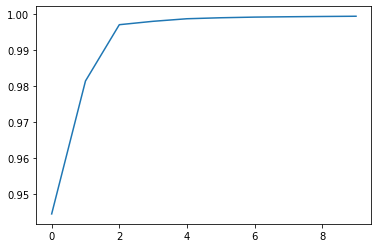

In [236]:
plt.plot(grid_search.best_estimator_.named_steps['prep'].transformers_[2][1].explained_variance_ratio_.cumsum())

## Define Strategy in a Function

Now for our trading strategy. I have a strategy from Sofien Kaabar, which aims to predict the direction of the S&P500 using the put/call ratio. However, his strategy is in realtime and does not yet employ any machine learning. Is it possible to predict the put/call ratio and make a trade based on our predictions?

According to Kaabar, if the put call ratio has increased from the previous trading day, we should short the market. And if it has decreased, then we should long it. This is an easy signal to create.

In [238]:
def signal1(Data):
  condition1 = 0.6
  positions = list(np.zeros(len(Data)))
  for i in range(len(Data)):     
      if Data[i] - Data[i-1] > 0:     
          positions[i] = -1
      elif Data[i] - Data[i-1] < 0:   
          positions[i] = 1
  return positions


## Plot Returns

Now that we have our signal, we can take our positions based on the results of the model. The train set shows amazing performance, creating a 500% increase on our initial investment in just 7 years.

Text(0.5, 0, 'Date')

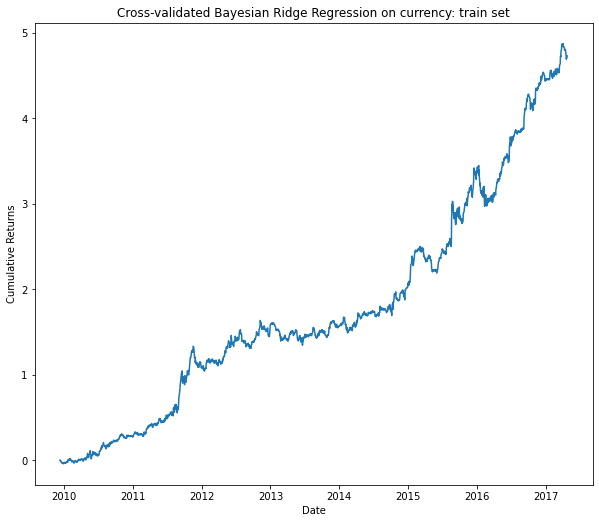

In [239]:

positions = signal1(grid_search.predict(x_train))
positions1 = signal1(grid_search.predict(x_test))



dailyRet = pd.Series(positions).fillna(0).values * retFut1_train
dailyRet = dailyRet.fillna(0)

dailyRet1 = pd.Series(positions1).fillna(0).values * retFut1_test
dailyRet1 = dailyRet1.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1
cumret1 = np.cumprod(dailyRet1 + 1) - 1

plt.figure(1, figsize=[10,8.5])
plt.plot(cumret.index, cumret)
plt.title('Cross-validated Bayesian Ridge Regression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')


Similarly, the test set shows an almost 140% increase in our intial investment in just 3 years.

Text(0.5, 0, 'Date')

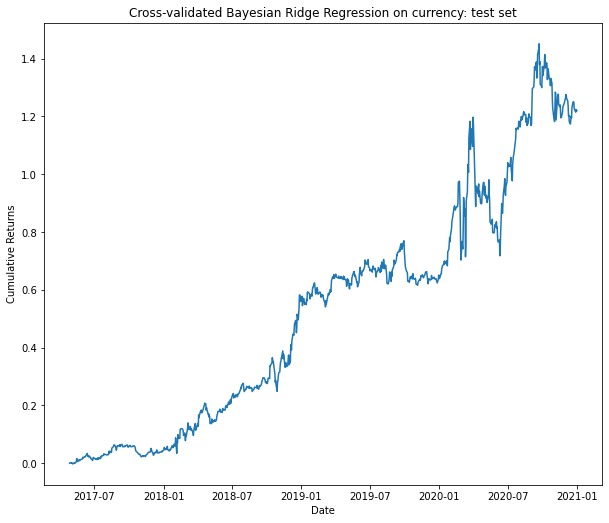

In [240]:
plt.figure(1, figsize=[10,8.5])
plt.plot(cumret1.index, cumret1)
plt.title('Cross-validated Bayesian Ridge Regression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

## Plot Residuals

The residual distribution above shows that the residuals are normally distributed around a mean of 0. The autocorrelation graph shows that the residuals are mostly white noise, with at outlier at 46 lags. This indicates that the residuals are not significantly autocorrelated.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Ljung-Box test p-value [6.95190438e-05]


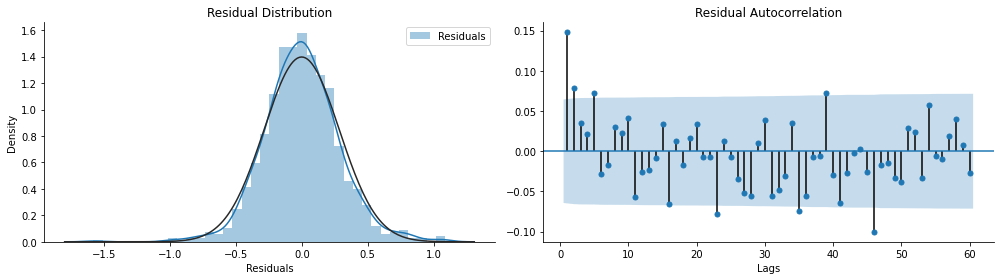

In [242]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=60, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("Residuals"))

#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb[1])


# Plot Feature Importance

Feature importances can be valuable in determining the best variables for predicting a target. In this case, the previous day's put/call ratio, day2, day 3, and day 4, were themost significant predictors.

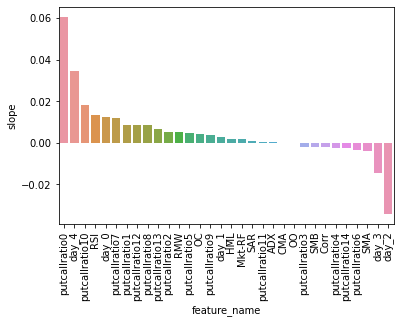

In [244]:
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), x_train.columns.values.tolist()))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): 
    item.set_rotation(90)
plt.show()



## Model Metrics

Now, let's calculate some model metrics to verify that the results are not attributable to statistical chance. 

In [245]:
from sklearn.metrics import accuracy_score
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
best_model.score(x_test, y_test)

0.08598879805640836

In [246]:
from sklearn.metrics import mean_squared_error

mean_squared_error(true_y, pred_y)

0.08149330953547015

In [247]:
from sklearn.metrics import r2_score
true_y = y_train.values.ravel()
pred_y = grid_search.predict(x_train)

print('R^2:', r2_score(true_y, pred_y))



R^2: 0.21275075155926415


In [248]:
cagr = (1 + cumret1[-1]) ** (252 / len(cumret1)) - 1
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet1)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6}').format(cagr, ratio))

Out-of-sample: CAGR=0.241837 Sharpe ratio=1.31369


The train set shows markedly better metrics that the test set, which is to be expected. 
Notable, the R2 and MSE for both the test and train set show that the model fit is highly imprecise. Nonetheless, the CAGR for both sets show incredible performance, showing a slight edge over the returns expected on the s&p500 index, with 24% for the test set.

# White's Reality Check

Performing White’s reality check on the results gives a p-value of 0.04. This is much smaller than 0.1, and we can thus reject the null hypothesis.

This indicates that the results are not due to the data mining bias, and that they are likely not attributable to a statistical fluke.


average return 0.003578
[-0.00397306  0.0041352 ]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.04400000000000004


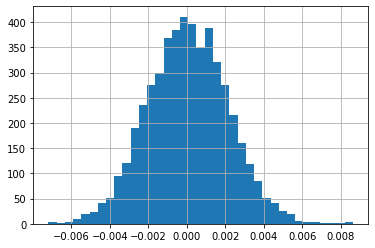

In [249]:

detrended_open = detrendPrice.detrendPrice(openp[start+int((end-start)*2/3):])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions1).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()